In [27]:
# imports
import functools
import numpy as np
import tensorflow as tf
import time
from tensorflow.python import debug as tf_debug

# a few decorator definitions to help build the model.
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator

def define_scope(function, scope=None, *args, **kwargs):
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# above code from ref: https://gist.github.com/danijar/8663d3bbfd586bffecf6a0094cd116f2
# via: https://danijar.com/structuring-your-tensorflow-models/


# tensorflow will only correctly handle python-based routines like time.process_time() if it is thrown into
#   a generator

def get_time():
    while True:
        yield np.array([time.process_time()]).astype('float32')
        

class Neuron:
    
    def __init__(self, size, inputs, posits, weights, biases, alpha, beta, gamma, 
                 theta, phi, mu, sigma, cutoff, period, idx, batch_size, neuron_type):

        self.size    = size    # total number of neurons
        self.inputs  = inputs  # output of cells feeding into this neuron
        self.posits  = posits  # coordinates to use as the 'x' argument for the 'closeness' functions
        self.weights = weights # weights associated with neurons from index 0 to this-1
        self.biases  = biases  # biases associated with neurons from index 0 to this-1
        self.alpha   = alpha   # alpha scales the 'closeness' functions
        self.beta    = beta    # beta is the power of the sin function, controls the curvature of the peaks
        self.gamma   = gamma   # gamma shifts the sin function up or down
        self.theta   = theta   # theta modifies the period of the sin function
        self.phi     = phi     # phi shifts the sin function left or right
        self.mu      = mu      # mu controls the mean of the gaussian function
        self.sigma   = sigma   # sigma controls the standard deviation of the gaussian function
        self.cutoff  = cutoff  # clips any smaller 'closeness' values to zero
        self.idx     = idx     # index of this neuron
        self.period  = period  # initial period for the sin function as defined in the model class.  
                               #   for images, this should be the width in pixels
            
        self.neuron_type = neuron_type  # one of: input, output, comp
        self.batch_size = batch_size    # batch size 
        
        # and we will control the range of the various variables used
        self.alpha_adjusted = tf.subtract(tf.multiply(tf.nn.sigmoid(self.alpha), 2.0), 1.0)
        self.beta_adjusted  = tf.add(self.beta, 1.0)
        self.gamma_adjusted = tf.nn.sigmoid(self.gamma)
        self.theta_adjusted = tf.divide(tf.nn.softplus(self.theta), tf.log(2.0))
        self.phi_adjusted   = self.phi
        self.sigma_adjusted = tf.nn.softplus(self.sigma)
        self.mu_adjusted    = self.mu
        
        # used to store the 'closeness' (distance) values produced for each neuron.
        self._dists_full = tf.get_variable('dist_shape_%d' % self.idx, initializer=tf.zeros([1, self.size]), trainable=False)
        
        # calling the relevant class methods to initialize them
        self.dists_normed
        self.dists_shaped
        self.output
        
    @define_scope
    def dists_normed(self):
        
        # input neurons don't need any 'closeness' functions, since they just feed deeper into the network
        if self.neuron_type == 'input':
            self._dists_normed = tf.zeros([1,self.idx+1], dtype=tf.float32)
        
        # defining the closeness functions for every other neuron.
        else:
            self.gaussian_part = tf.exp(
                                    tf.multiply(
                                        -1.0,
                                        tf.divide(
                                            tf.pow(
                                                tf.subtract(
                                                    self.posits, 
                                                    self.mu_adjusted
                                                ), 
                                                2.0
                                            ), 
                                            tf.multiply(
                                                2.0, 
                                                tf.pow(
                                                    self.sigma_adjusted, 
                                                    2.0
                                                )
                                            )
                                        )
                                    )
                                )
            
            # this formulation of the sin part allows simple use of the period of the data.
            self.sin_part = tf.pow(
                                tf.add(
                                    0.501, # not sure if that 01 is necessary anymore.  was avoiding a div by 0
                                    tf.multiply(
                                        0.5,
                                        tf.sin(
                                            tf.add(
                                                tf.multiply(
                                                    tf.divide(
                                                        tf.multiply(
                                                            2.0,
                                                            np.pi
                                                        ),
                                                        tf.multiply(
                                                            self.period,
                                                            self.theta_adjusted
                                                            )
                                                    ),
                                                    self.posits
                                                ),
                                                self.phi_adjusted
                                            )
                                        )
                                    )
                                ),
                                self.beta_adjusted
                            )
            
            # applying the vertical shift to the sin part, multiplying by the gaussian, scaling by alpha
            self.dist_vals = tf.multiply(
                                    self.alpha_adjusted,
                                    tf.multiply(
                                        self.gaussian_part,
                                        tf.subtract(
                                            self.sin_part, 
                                            self.gamma_adjusted
                                        )
                                    )
                                )

            # next, we're applying the cutoff and rescaling so that the min magnitude is 0
            self._dists_normed = tf.where(
                                    tf.greater(
                                        tf.abs(self.dist_vals),
                                        tf.add(
                                            tf.zeros_like(self.dist_vals),
                                            self.cutoff
                                        )
                                    ),
                                    tf.divide(
                                        tf.multiply(
                                            tf.subtract(
                                                tf.abs(self.dist_vals),
                                                self.cutoff
                                            ), 
                                            tf.sign(self.dist_vals)
                                        ),
                                        tf.subtract(
                                            1.0,
                                            self.cutoff
                                        )
                                    ),
                                    tf.zeros_like(self.dist_vals)
                                )
        return self._dists_normed

    @define_scope
    def dists_shaped(self):
        self._dists_shaped = self._dists_full[0,:self._dists_normed.get_shape()[1]].assign(
                                                            tf.reshape(self._dists_normed, [-1]))
        return self._dists_shaped


    @define_scope
    def output(self):
        
        # input nodes simply output the input data at a given index
        if self.neuron_type == 'input':
            self._output = tf.reshape(self.inputs, [self.batch_size,1])

        # computational nodes apply the weights and biases of previous neurons to the transmitted signal
        if self.neuron_type == 'comp':
            self._output = tf.reshape(
                                tf.reduce_sum(
                                    tf.multiply(
                                        self._dists_normed,
                                        tf.nn.leaky_relu(
                                            tf.add(
                                                tf.multiply(
                                                    self.inputs, 
                                                    self.weights
                                                ), 
                                                self.biases
                                            )
                                        )
                                    ),
                                    1
                                ), 
                                [self.batch_size,1]
                            )

        # output neurons here act similarly to computaitonal neurons, but without sigmoid activation
        if self.neuron_type == 'output':
            self._output = tf.reshape(
                                tf.reduce_sum(
                                    tf.multiply(
                                        self._dists_normed,
                                        tf.add(
                                            tf.multiply(
                                                self.inputs, 
                                                self.weights
                                            ), 
                                            self.biases
                                        )
                                    ),
                                    1
                                ), 
                                [self.batch_size,1]
                            )

        return self._output
    
# Neuron class is done now.  Next up is the model.
               
class Model:
    
    def __init__(self, n_neurons, n_inputs, n_outputs, data, target, last_time, batch_size):
        self.n_neurons = n_neurons
        self.n_inputs  = n_inputs
        self.n_outputs = n_outputs
        self.n_comps   = self.n_neurons - self.n_inputs - self.n_outputs
        self.last_time = last_time     
        self.batch_size = batch_size
        # max_knex is the maximum number of meaningful elements in the adjacency matrix representation
        self.max_knex = 0.5*tf.cast(tf.pow(self.n_neurons, 2) - tf.pow(self.n_inputs, 2) - tf.pow(self.n_outputs, 2) - self.n_comps, tf.float32)
        self.data = data
        self.target = target
        
        # calling the relevant class methods to initialize them for Tensorflow.  Order matters here.
        self.init_model
        self.dists
        self.inference
        self.flow_diffs
        self.loss_metric
        self.this_time
        self.pct_knex
        self.loss
        self.optimize
    
    @define_scope
    def init_model(self):
        # neuron-wise coordinates/ inputs to feed into the Neuron class
        self.inputs = {}
        self.posits = {}
        
        # global cutoff to apply to 'closeness' values in order to enforce sparcity
        self._cutoff=tf.get_variable('cutoff', initializer=tf.constant(-1.0), trainable=True)
        self.cutoff = tf.nn.sigmoid(self._cutoff)
        
        # a coherent period (if applicable) in the data.  Eg, image width of 28 pixels for mnist
        self._period = 28.0
        self.period = tf.cast(self._period, tf.float32)
        self.regularizer = tf.contrib.layers.l1_regularizer(scale=0.1)

        # coordinate plane values to pass as the 'x' argument to the 'closeness' functions
        self.x=np.arange(self.n_neurons-self.n_outputs).astype('float32')
        self.y=np.arange(self.n_inputs, self.n_neurons).astype('float32')
        self.Y,self.X = tf.meshgrid(self.x, self.y)
        
        # this displacement bit simply shifts the zero points such that they dont lie along the diagonal, 
        #   but rather begin at the first input neuron's output (for the first computational neuron),
        #   and end at the last computational neuron's output (for the last output neuron)
        self.displacement = tf.tile(
                                tf.reshape(
                                    tf.cast(
                                        np.linspace(
                                            self.n_inputs, 
                                            self.n_outputs, 
                                            self.n_neurons-self.n_inputs
                                        ), 
                                        tf.float32
                                    ),
                                    [-1, 1]
                                ), 
                                np.array([1, self.n_neurons-self.n_outputs])
                            )

        self.positions = (self.Y-self.X)+self.displacement
        
        # next up, defining some initial values for the various trainable parameters
        
        # alpha scales the 'closeness' functions
        #   range control of alpha : 2*sigmoid(alpha) - 1
        self.alpha_init  = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=5.0,
                                stddev=1.0
                            )
        # beta is the power of the sin function, controls the curvature of the peaks
        #   range control of beta : beta + 1
        self.beta_init   = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=0.0,
                                stddev=0.01
                            )
        # gamma shifts the sin function up or down
        #   range control of gamma : sigmoid(gamma)
        self.gamma_init = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=0.0,
                                stddev=1.0
                            )
        # theta modifies the period of the sin function
        #   range control of theta : softplus(theta) / log(2.0)
        self.theta_init  = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=0.0,
                                stddev=1.0
                            )
        # phi shifts the sin function left or right
        #   range control of phi : phi
        self.phi_init    = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=0.5*np.pi, 
                                stddev=0.01*np.pi 
                            )
        # sigma controls the standard deviation of the gaussian function
        #   range control of sigma : softplus(sigma)
        self.sigma_init  = tf.random_normal(
                                shape=[self.n_neurons, 1], 
                                mean=tf.pow(tf.cast(self.n_inputs, tf.float32), 0.66),
                                stddev=tf.pow(tf.cast(self.n_neurons, tf.float32), 0.33)
                            )
        # mu controls the mean of the gaussian function
        #   range control of mu : mu
        self.mu_init     = tf.random_normal(
                                shape=[self.n_neurons, 1],
                                mean=0.0,
                                stddev=14.0
                            )
        self.weight_init = tf.random_normal(
                                shape=[1, self.n_neurons],
                                mean=0.0,
                                stddev=1.0
                            )
        self.bias_init   = tf.random_normal(
                                shape=[1, self.n_neurons],
                                mean=0.0,
                                stddev=1.0
                            )

        # then, defining the actual tf variables.
        self.alphas  = tf.get_variable('alphas',  initializer=self.alpha_init )
        self.betas   = tf.get_variable('betas',   initializer=self.beta_init  )
        self.gammas  = tf.get_variable('gammas',  initializer=self.gamma_init )
        self.thetas  = tf.get_variable('thetas',  initializer=self.theta_init )
        self.phis    = tf.get_variable('phis',    initializer=self.phi_init   )
        self.sigmas  = tf.get_variable('sigmas',  initializer=self.sigma_init )
        self.mus     = tf.get_variable('mus',     initializer=self.mu_init    )
        self.weights = tf.get_variable('weights', initializer=self.weight_init)
        self.biases  = tf.get_variable('biases',  initializer=self.bias_init  )
        
        # lists to hold the neurons, 'closeness' function values.  not pretty, I know.  but it works.
        self.neurons = []
        self.neuron_dists = []
        
        for i in range(self.n_neurons):
            
            # some slicing and dicing
            if i<self.n_inputs:
                neuron_type = 'input'
                self.posits['posit_%d' % i] = tf.zeros([1, self.n_neurons-self.n_outputs])
                self.inputs['input_%d' % i] = tf.slice(
                                                    self.data, 
                                                    [0,i], 
                                                    [self.batch_size,1]
                                                )

            elif i>=(self.n_neurons-self.n_outputs):
                neuron_type = 'output'
                self.posits['posit_%d' % i] = tf.slice(
                                                    self.positions,
                                                    [i-self.n_inputs, 0],
                                                    [1,self.n_neurons-self.n_outputs]
                                                )
                self.inputs['input_%d' % i] = tf.concat(
                                    [self.neurons[i]._output for i in range(0,self.n_neurons-self.n_outputs)],
                                    axis=1
                                )
                
            else:  
                neuron_type = 'comp'
                self.posits['posit_%d' % i] = tf.slice(
                                                    self.positions,
                                                    [i-self.n_inputs, 0],
                                                    [1, i]
                                                )
                self.inputs['input_%d' % i] = tf.concat(
                                            [self.neurons[i]._output for i in range(0,i)],
                                            axis=1
                                        )
            
            # building out and initializing each neuron
            self.neurons.append(
                Neuron(
                    self.n_neurons,
                    self.inputs['input_%d' % i],
                    self.posits['posit_%d' % i],
                    tf.slice(self.weights, [0,0], [1, min(i, self.n_neurons-self.n_outputs)]),
                    tf.slice(self.biases, [0,0], [1, min(i, self.n_neurons-self.n_outputs)]),
                    self.alphas[i],
                    self.betas[i],
                    self.gammas[i],
                    self.thetas[i],
                    self.phis[i],
                    self.mus[i], 
                    self.sigmas[i],
                    self.cutoff,
                    self._period,
                    i,
                    self.batch_size,
                    neuron_type
                )
            )

            # and storing the closeness functions
            self.neuron_dists.append(self.neurons[i]._dists_shaped)



    @define_scope
    def dists(self):
        # concatenating the rows together to from the full ('closeness') adjacency matrix
        self._dists = tf.concat(
                            [tf.slice(
                                self.neurons[i]._dists_shaped, 
                                [0,0], 
                                [1,self.n_neurons-self.n_outputs]
                            ) for i in range(self.n_inputs,self.n_neurons)],
                            axis=0
                        )

        return self._dists


    @define_scope
    def inference(self):
        # collects the output data (ie: the predictions)
        self.final_output = [self.neurons[i]._output for i in range(self.n_neurons-self.n_outputs,self.n_neurons)]
        
        # for mnist, I squred the results to get all non-negative values.
        self.out_tensor = tf.square(tf.reshape(tf.concat(self.final_output, axis=1), [self.batch_size, self.n_outputs]))

        return self.out_tensor
    

    @define_scope
    def flow_diffs(self):

        # only applies to computational nodes (connections directly from input to output neurons would cancel)
        
        # adjacency matrix elements representing connections starting from an input neuron and terminating at 
        #   a computational neuron
        self.input_outputs = tf.reduce_sum(
                                tf.concat(
                                    [tf.slice(
                                        tf.abs(self.neurons[i]._dists_normed), 
                                        [0,0], 
                                        [1, self.n_inputs]
                                    ) for i in range(self.n_inputs, self.n_neurons-self.n_outputs)],
                                    0
                                    )
                                )

        # adjacency matrix elements representing connections starting from a computational neuron and
        #   terminating at an output neuron
        self.output_inputs = tf.reduce_sum(
                                tf.concat(
                                    [tf.slice(
                                        tf.abs(self.neurons[i]._dists_normed), 
                                        [0,self.n_inputs], 
                                        [1, self.n_comps]
                                    ) for i in range(self.n_neurons-self.n_outputs, self.n_neurons)],
                                    0
                                    )
                                )

        # using L2 regularization for the flow term in the loss to give more flexibility at near 0 difference
        self._flow_loss = tf.reduce_mean(tf.square(tf.subtract(self.input_outputs, self.output_inputs)))
        
        return self._flow_loss
            

    @define_scope
    def pct_knex(self):
        # counting all non-zero elements in the adjacency matrix, dividing by total to get pct.
        self._pct_knex = tf.divide(tf.reduce_sum(
                            tf.where(
                                tf.greater(
                                    tf.abs(self._dists),
                                    tf.zeros_like(self._dists)
                                ),
                                tf.ones_like(self._dists),
                                tf.zeros_like(self._dists)
                            )
                        ), self.max_knex) 
        return self._pct_knex

    @define_scope
    def loss_metric(self):
        # defining the objective loss term
        
        # for mnist, softmax cross entropy
        self._loss_metric = tf.reduce_mean(
                                tf.nn.softmax_cross_entropy_with_logits(
                                    labels=self.target, 
                                    logits=self.inference
                                )
                            )

        return self._loss_metric


    @define_scope
    def this_time(self):
        self._this_time = time_frame

        return self._this_time
    

    @define_scope
    def loss(self):
        self.reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        self.time_diff = tf.subtract(tf.reshape(self._this_time, []), tf.reshape(self.last_time, []))
        self.time_pow = 1.0
        self.flow_coeff = 0.0001
        self.spars_coeff = 0.1
        self.obj_coeff = 1000.0
        self._loss = (self.obj_coeff*self._loss_metric + # objective losee
                      (self.flow_coeff*self._flow_loss) + # L2 flow loss (/regularization)
                      (self.spars_coeff*tf.pow(self._pct_knex, 2.0))  # L2 sparcity loss (/regularization)
                     )
        
        return self._loss
    

    @define_scope
    def optimize(self):
        # optimization op
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.002)
        
        # and an alternate optimization using gradient clipping
        
        #self.gvs = self.optimizer.compute_gradients(self._loss)
        #self.capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in self.gvs]
        #self.train_op = self.optimizer.apply_gradients(self.capped_gvs)
        #
        #return self.train_op
        
        return self.optimizer.minimize(self._loss)
        
# Thats all, now the network is ready to use.


In [2]:
1+1

2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
init time is 351 seconds
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800

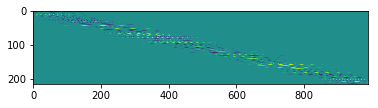

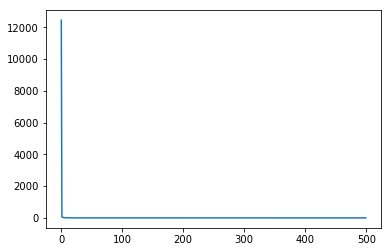

In [3]:
# and we can test it here on some simple data.  In this case, mnist

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

log_dir = '/home/miej/projects/4/logs/'

# instantiating the tf session
sess=tf.Session()

# in case we want to track how long this took
starting_time = time.time()

# basic definitions of # of nodes in the network and batch size
n_neurons = 1000
n_inputs = 784
n_outputs = 10
batch_size = 50
t_start = time.process_time()

# tensorflow doesnt like retrieving data from python routines, so it must be called via a generator
#   this is the most efficient way I've found to get it working properly.
time_data = get_time()
time_dataset = tf.contrib.data.Dataset.from_generator(lambda: time_data, tf.float32)
time_frame = time_dataset.make_one_shot_iterator().get_next()

# defining up some placeholders for our iteration inputs
data = tf.placeholder(tf.float32, [None,n_inputs])
target = tf.placeholder(tf.float32, [None,n_outputs])
last_time = tf.placeholder(tf.float32, [1])

# and instantiating the model class. (and all neurons in the network)
this_model = Model(n_neurons, n_inputs, n_outputs, data, target, last_time, batch_size)

# initializing variables
sess.run(tf.global_variables_initializer())
t_train=time.time()

# creating some lists to record network metrics

dist_list = []   # the adjacency matrices
loss_vals = []   # the total loss values used for the backprop
loss_mets = []   # the objective losses
flow_diffs = []  # the flow losses
spars_list = []  # the sparcity losses
tloss_list = []  # the time losses 
accs = []        # the accuracy (on a random batch-size selection of samples from the test set)

# in case you want to view the loss in tensorboard..
with tf.name_scope('summary'):
    tf.summary.scalar('loss', this_model._loss)
    
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(log_dir,
                                      sess.graph)

train_writer.add_graph(sess.graph)

# model is initialized now, and we can prepare to train
print('init time is %d seconds' % (t_train-starting_time))

# an initial placeholder value for the last time since it's undefined at the first step
last_time_in = np.array([time.process_time()])

# in this example, i'm running the network for 50k steps with a batch size of 50, so the 
#   network will see a total of 2.5M training examples

for i in range(50000):
    batch = mnist.train.next_batch(batch_size)
    
    this_data = batch[0]
    this_target = batch[1]
    
    # and in order to save a little time/memory (especially since we will also be storing the full
    #   adjacency matrices), we will only record metrics every 100 steps
    if i % 100 == 0:
        print(i)
        _, dists_out, loss_metric_out, loss_out, time_out, flow_out, knex_out, summary, tloss_out= sess.run([this_model.optimize, 
                                                           this_model._dists,
                                                           this_model.loss_metric,
                                                           this_model.loss, 
                                                           this_model.this_time,
                                                            this_model._flow_loss,
                                                            this_model.pct_knex,
                                                            merged,
                                                            this_model.time_diff],
                                                              feed_dict={data:this_data, 
                                                                        target:this_target,
                                                                        last_time:last_time_in})
        train_writer.add_summary(summary, i)
        flow_diffs.append(flow_out)
        spars_list.append(knex_out)
        tloss_list.append(tloss_out)
        dist_list.append(dists_out)
        loss_vals.append(loss_out)
        loss_mets.append(loss_metric_out)
        
        # and setting the last loss/time values again
        last_time_in = time_out
        
    # the rest of the time, we will just run the training steps without storing metrics
    else:
        _, = sess.run([this_model.optimize],
                        feed_dict={
                            data:this_data, 
                            target:this_target,
                            last_time:last_time_in
                        })

    # also, every 100 steps, we will measure the network's accuracy on 50 samples from the test set
    if i % 100 == 0:
        test_batch = mnist.test.next_batch(batch_size)
        test_data = test_batch[0]
        test_objective = test_batch[1]

        loss, prediction_out = sess.run([this_model.loss, this_model.inference], 
                                        feed_dict={data: test_data, 
                                                   target: test_objective,
                                                    last_time:last_time_in})

        test_label=([np.argmax(item) for item in test_objective])
        test_pred=([np.argmax(item) for item in prediction_out])

        new_acc = np.mean([1 if test_pred[k]==test_label[k] else 0 for k in range(len(test_pred))])
        accs.append(new_acc) 

# done training now, finishing out by checking how long it took, and printing out the initial adjacency 
#   matrix, as well as the objective losses
print('time required for all steps is %d' % (time.time() - t_train))

import matplotlib.pyplot as plt
plt.imshow(dist_list[0])
plt.show()

plt.plot(loss_mets[:])
plt.show()

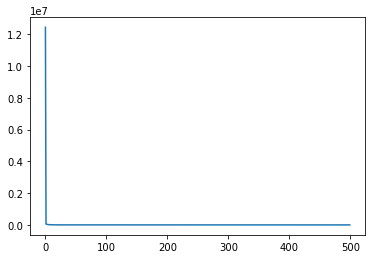

In [4]:
# obviously 39333 seconds is a long time to train a model on mnist.  
# That said, we've already discussed the current limitations of this architecture in the readme.

# lets look at some of those metrics we stored.  starting with the total loss value
plt.plot(loss_vals[:])
plt.show()

0.98


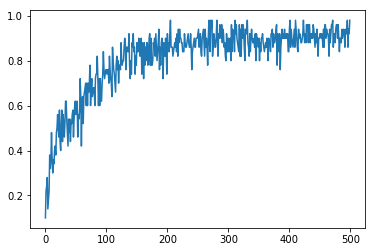

In [5]:
# next, looking at the accuracy on the test set (50 items)

# obviously 98% on mnist isnt particularly great, but this generally demonstates that the model
#   is in fact feasible.

print(accs[-1])
plt.plot(accs[:])
plt.show()

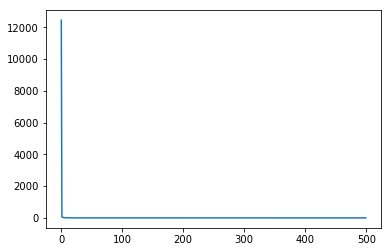

In [6]:
# the objective loss term
plt.plot(loss_mets[:])
plt.show()

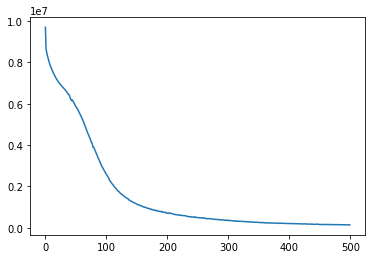

In [7]:
# the flow loss term
plt.plot(flow_diffs[:])
plt.show()

0.0307035


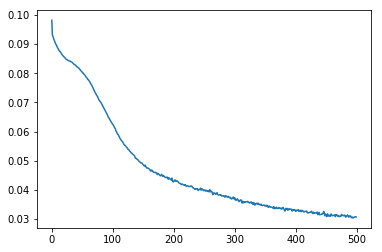

In [8]:
# the sparcity loss term

# I think this one is pretty neat.  at the end of the training, the model hit 98% 
#   accuracy on mnist while utilizing only 3% of total possible neuron-neuron connections
#   and it hadn't even plateaued out yet, meaning greater than 98% accuracy at less than 
#   3% utilization is almost certainly possible

print(spars_list[-1])
plt.plot(spars_list[:])
plt.show()

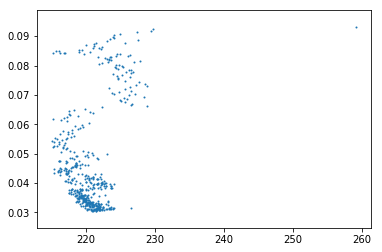

In [9]:
# here we're looking at the scatterplot of the sparcity vs time.

# for only dense tensor methods, i'd expect this to just be a straight, vertical line. 
#   instead, theres some clear structure, suggesting under-the-hood optimizations of one
#   flavor or another

plt.scatter(tloss_list[1:], spars_list[1:], s=1)
plt.show()

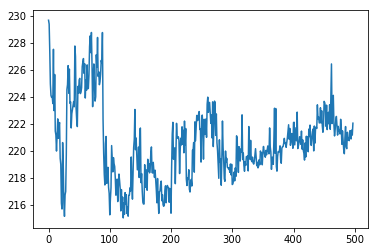

In [10]:
# the time required for a step through the training cycle
plt.plot(tloss_list[2:])
plt.show()

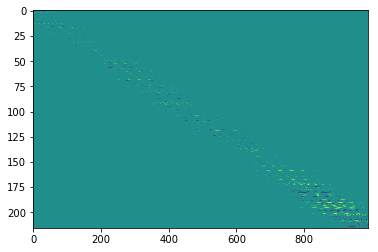

In [29]:
# but this is what you guys are really here for right?  you want to see how the network evolves over time
#   in a pretty matplotlib animation, right?  here you go.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


fig = plt.figure()
im = plt.imshow(dist_list[0], aspect='auto')
def updatefig(j):
    im.set_array(dist_list[j])
    return [im]


anim = animation.FuncAnimation(fig, updatefig, frames=500, 
                              interval=50, blit=True)

HTML(anim.to_html5_video())

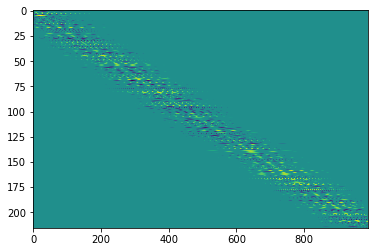

In [12]:
# ah.. I think jupyter doesn't want to keep the video cached, so please reference the following link for
#   the video that should have appeared above: https://www.youtube.com/watch?v=pGY5WF2VHV8

# below the video is what the network's adjacency matrix looks like at the end of the training cycle, so 
#   let's also remind ourselves what it looked like at the beginning.

plt.imshow(dist_list[0], aspect='auto')
plt.show()

In [28]:
# some things to note:  

# - the network doesnt really seem to like shifting the mean of the gaussian functions left or right.  
#     I'm not really sure why offhand.
#
# - there's clearly more of a focus of neuron connections around the range of neurons number 300-500,
#     or in other words, around the center of the images, where much of the uniquely indentifying data
#     can be found
#
# - after neuron number 784 (the last of the input neurons), there is a relatively dense section of 
#     purely computational neuron-computational neuron connections.  this makes sense. the network is 
#     maintaining depth.
# 
